# Document Classification On Imbalanced Data
------------------

## Table of Contents

__[1. Introduction](#first-bullet)__

__[2. Creating The Imbalanced Dataset](#second-bullet)__

__[3. Preprocessing & Feature Extraction](#third-bullet)__

__[4. The Naive Bayes Model & Scikit-learn Pipeline](#fourth-bullet)__

__[5. Handling Imbalanced Data](#fifth-bullet)__

__[6. Stop Word Removal](#sixth-bullet)__

__[7. HyperParameter Tunning With GridSearchCV](#seventh-bullet)__

__[8. Conclusions](#eigth-bullet)__


---------

## Introduction <a class="anchor" id="first-bullet"></a>
-----------

Natural language processing or NLP is an hot topic in data science and machine learning.  While research in NLP dates back to the 1950's, the real revolution in this domain came in 1980's and 1990's with the introduction of statistical models and fast computational power. Before this most language processing tasks made use of hand-coded rules which were generally not very robust.

The span of topics in Natural Language Processing is immense and I'll just getting to the tip of the iceberg with going over the topic of [document classification](https://en.wikipedia.org/wiki/Document_classification) also known as [text classification](https://monkeylearn.com/text-classification/).  I will be working with the <a href="http://scikit-learn.org/">Scikit-learn</a> library and using its provided dataset the <a href="http://qwone.com/~jason/20Newsgroups/">20 News Groups</a>, but with a twist to make it more realistic. The 20 New Groups is collection of almost 20,000 articles on 20 different topics or 'newsgroups' and we will use a subset of the data and tweak the data so that it is imbalanced.  Having imbalanced makes the developing a good model more challenging, but it is also more realistic.  Imbalanced classes often occur in classification problems and may times it is too expensive or not possible to get more data on the classes that have to few samples. Developing strategies for dealing with imbalanced data is paramount for creating good classification models.

Let's dive into the data! 

## Creating The Imbalanced Dataset <a class="anchor" id="second-bullet"></a>

We can obtain the training and testing sets directly from Scikit-Learn the following commands:

In [1]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train', shuffle=True)
twenty_test  = fetch_20newsgroups(subset='test', shuffle=True)

We can then view the total number of articles:

In [2]:
len(twenty_train.data) + len(twenty_test.data)

18846

All the documents within the data set belong to the following 20 topics,

In [3]:
twenty_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can look at the actual message within the documents,

In [4]:
doc = "\n".join(twenty_train.data[0].split("\n"))
print(doc)

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







But if we look at the target classes they are actually encoded using a categorical variable,

In [5]:
twenty_train.target[0]

7

In order to view the human readible version of the target we create a dictionary to map the categorical variables (numbers) to labels:

In [6]:
codings = list(range(len(twenty_train.target_names)))
target_dic = dict(zip(codings,twenty_train.target_names))

Now we can see the actual document's topic:

In [7]:
target_dic[twenty_train.target[0]]

'rec.autos'

Let's take a the dictionary:

In [8]:
target_dic

{0: 'alt.atheism',
 1: 'comp.graphics',
 2: 'comp.os.ms-windows.misc',
 3: 'comp.sys.ibm.pc.hardware',
 4: 'comp.sys.mac.hardware',
 5: 'comp.windows.x',
 6: 'misc.forsale',
 7: 'rec.autos',
 8: 'rec.motorcycles',
 9: 'rec.sport.baseball',
 10: 'rec.sport.hockey',
 11: 'sci.crypt',
 12: 'sci.electronics',
 13: 'sci.med',
 14: 'sci.space',
 15: 'soc.religion.christian',
 16: 'talk.politics.guns',
 17: 'talk.politics.mideast',
 18: 'talk.politics.misc',
 19: 'talk.religion.misc'}

One piece of termanology that is used frequently in NLP is the text <a href="https://en.wikipedia.org/wiki/Text_corpus">**corpus**</a>. The text corpus is a large set of texts and can be used to describe what the `twent_train.data` and `twenty_test.data` datasets are.


Let's alter the data and **only consider at those documents in the corpus that are related to recreation**, i.e. the labels:


In [9]:
new_labels = ["rec.autos", "rec.motorcycles","rec.sport.baseball","rec.sport.hockey"]

The twety new groups isn't quite stored as structured data, so in order to filter out the non-recreation documents we'll have to convert the datasets to [Pandas](https://pandas.pydata.org/) dataframes to work with it easier:

In [10]:
import pandas as pd 

train_df = pd.DataFrame({"text"  : twenty_train.data,
                         "target": twenty_train.target})

# filter out non-recreation documents
train_df  = train_df[train_df["target"].isin([7,8,9,10])]


test_df = pd.DataFrame({"text"  : twenty_test.data,
                        "target": twenty_test.target})

# filter out non-recreation documents
test_df   = test_df[test_df["target"].isin([7,8,9,10])]

Let's take a look at the number of samples in the training and test set:

In [11]:
train_df.groupby("target").size()

target
7     594
8     598
9     597
10    600
dtype: int64

In [12]:
test_df.groupby("target").size()

target
7     396
8     398
9     397
10    399
dtype: int64

All of the classes have about the same number of samples.  We'll choose `hockey` as the class to shrink so that the data is imbalanced, i.e. we'll reduce it by 75%:

In [13]:
# subset the hockey class
train_hockey_df     = train_df[train_df["target"] == 10].sample(frac=0.25)
train_no_hockey_df  = train_df[train_df["target"] != 10]

# get the rest of the clases
test_hockey_df     = test_df[test_df["target"] == 10].sample(frac=0.25)
test_no_hockey_df  = test_df[test_df["target"] != 10]

# combine the training and test sets to be imbalanced datasets
imbal_train_df = pd.concat([train_hockey_df, train_no_hockey_df], axis=0)
imbal_test_df  = pd.concat([test_no_hockey_df, test_hockey_df], axis=0)

We can take at the absolute numeber and percentages:

In [14]:
print("Counts:", imbal_train_df.groupby("target").size())

Counts: target
7     594
8     598
9     597
10    150
dtype: int64


In [15]:
print("Class percent:", 100 * imbal_train_df.groupby("target").size() / imbal_train_df.shape[0])

Class percent: target
7     30.634348
8     30.840640
9     30.789067
10     7.735946
dtype: float64


In [16]:
print("Class percent:", 100 * imbal_test_df.groupby("target").size() / imbal_test_df.shape[0])

Class percent: target
7     30.673896
8     30.828815
9     30.751356
10     7.745933
dtype: float64


From now on we'll be working with the imbalanced dataframes `imbal_train_df` and `imbal_test_df`.  Now that we have an idea of what kind of data we are working with we can start to do some machine learning on it.  As with all datasets there is some required preprocessing before machine learning.  With numerical data there needs to be some cleaning and <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html">scaling</a> of the features. However, in Natural Language Processing there is much more substantial preprocessing stage that we'll go over next.

## Preprocessing & Feature Extraction <a class="anchor" id="third-bullet"></a>
--------------------

The first thing we need to go over is the concept of the <a href="https://en.wikipedia.org/wiki/Bag-of-words_model">**bag of words model**</a>.  *In the bag-of-words model, a text (such as a sentence or a document) is represented as "bag" or list of its words, disregarding grammar and even word order, but keeping multiplicity of the words.*  A two document example is:

- **D1:**  Hi, I am Mike and I like Boston.

- **D2:**  Boston is a city and people in Boston like the Red Sox.

From these two documents, a list, or 'bag-of-words' is constructed

    bag = ['Hi', 'I', 'am', 'Mike', 'and', 'like', 'Boston', 'is', 
           'a', 'city, 'and', 'people', 'in', 'the', 'red', 'sox]


Notice how in our bag-of-words we have dropped repetitions of the words 'I', 'is' and 'Mike', we will show how multiplicity of words enters into our model next. 

The bag-of-words model is mainly used as a tool of feature generation. After transforming the text into a "bag of words", we can calculate various measures to characterize the document.  In order to do so we have to generate a vector for each document that represents the number of times each entry in the bag of words appears in the text. The order of entries in the vector corresponds to the order of the entries in the bag-of-words list.  For example, document D1 would have a vector,

    [1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0 ,0, 0, 0, 0, 0]
    
while the second document, D2, would have the vector,

    [0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]

Each entry of the lists refers to frequency or count of the corresponding entry in the bag-of-words list.  When we have a stacked collection of (row) vectors, or matrix, where each row corresponds to a document (vector), and each column corresponds to a word in the bag-of-words list, then this will be known as our **term-frequency ($\text{tf}$) [document matrix](https://en.wikipedia.org/wiki/Document-term_matrix)**. The general formula for an entry in the $\text{tf}$ matrix is,

$$\text{tf}(d,t) \,  = \, f_{t,d}$$
    
where $f_{t,d}$ is the number of times the term $t$ occurs in document $d \in \mathcal{D}$, where $\mathcal{D}$ is our text corpus. We can create a term-frequency matrix for the above example using Scikit-learns <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer">CountVectorizer</a> class:

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer =  CountVectorizer()

corpus     = ["Hi, I am Mike and I like Boston.",
              "Boston is a city and people in Boston like the Red Sox."]

# get the term frequency
tf  = vectorizer.fit_transform(corpus)

# get the words in bag-of-words
print(vectorizer.get_feature_names())

# get the counts!
print(tf.toarray())

['am', 'and', 'boston', 'city', 'hi', 'in', 'is', 'like', 'mike', 'people', 'red', 'sox', 'the']
[[1 1 1 0 1 0 0 1 1 0 0 0 0]
 [0 1 2 1 0 1 1 1 0 1 1 1 1]]


The order of the words is off and CountVectorizer dropped single letter words and punctutation, but the rest is the same!

**Notice CountVectorizer converts everything to lowercase, drops single letter words and punctuation.**

Let's try CountVectorizer on our dataset:

In [18]:
count_vect = CountVectorizer()

X_train_tf = count_vect.fit_transform(imbal_train_df["text"])

print("Shape of term-frequency matrix:", X_train_tf.shape)

Shape of term-frequency matrix: (1939, 26901)


The term-frequency is a sparse matrix where each row is a document in our training corpus ($\mathcal{D}$) and each column corresponds to a term/word in the bag-of-words list. This can be confirmed by comparing the number of rows in the term-frequency matrix to the number of documents in the training set:

In [19]:
print("Number of training documents: ", imbal_train_df.shape[0])

Number of training documents:  1939


Most often term-frequency alone is not a good measure of the importance of a word/term to a document's topic.  Very common words like "the", "a", "to" are almost always the terms with the highest frequency in the text. Thus, having a high raw count of the number of times a term appears in a document does not necessarily mean that the corresponding word is more important. Furtermore, longer documents could have high frequency of terms that do not correlate with the document topic, but instead occur with high numbers solely due to the length of the document.

To circumvent the limination of term-frequency, we often normalize it by the **inverse document frequency (idf)**.  This results in the **term frequency-inverse document frequency (tf-idf)** matrix.  The *inverse document frequency is a measure of how much information the word provides, that is, whether the term is common or rare across all documents in the corpus*.  We can give a formal defintion of the inverse-document-frequency by letting $\mathcal{D}$ be the corpus or the set of all documents and $N$ is the number of documents in the corpus and $N_{t,D}$ be the number of documents that contain the term $t$ then, 

$$idf(t,\mathcal{D}) \, = \,  \log\left(\frac{N_{\mathcal{D}}}{1 + N_{t,\mathcal{D}}}\right) \, = \, -  \log\left(\frac{1 + N_{t,\mathcal{D}}}{N_{\mathcal{D}}}\right) $$

The reason for the presence of the $1$ is for smoothing.  Without it, if the term/word did not appear in any training documents, then its inverse-document-frequency would be $idf(t,\mathcal{D}) = \infty$.  However, with the presense of the $1$ it will now have $idf(t,\mathcal{D}) = 0$.


Now we can formally defined the term frequnecy-inverse document frequency as a normalized version of term-frequency,


$$\text{tf-idf}(t,d) \, = \, tf(t,d) \cdot idf(t,\mathcal{D}) $$

Like the term-frequency, the term frequency-inverse document frequency is a sparse matrix, where again, each row is a document in our training corpus ($\mathcal{D}$) and each column corresponds to a term/word in the bag-of-words list.  The $\text{tf-idf}$ matrix can be constructed using the sklearn <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html">TfidfTransformer</a> class:

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_tf)
X_train_tfidf.shape

(1939, 26901)

We should note that the $\text{tf-idf}$ matrix is the same shape as the $\text{tf}$ matrix, but the two have different values.


Now that we have built our $\text{tf-idf}$ matrix we can start to look at the which terms/words are most associated with document topics and then build a predictive model to classify the documents' topic. Let's first go over the model we will be using for prediction.

## The Naive Bayes Model & Scikit-learn Pipelines<a class="anchor" id="fourth-bullet"></a>
-------------------

### The Naive Bayes Model
-------------------

One of the most basic models for text classification is the <a href="https://en.wikipedia.org/wiki/Naive_Bayes_classifier">Naive Bayes model</a>. The Naive Bayes classification model predicts the document topic, $y = \{C_{1},C_{2},\ldots, C_{k}\}$ where $C_{k}$ is the class or topic based on the document feactures $\textbf{x} \in \mathbb{N}^{p}$,  and $p$ is the number of terms in our bag-of-words list.  The feature vector,

$$\textbf{x} \, = \, \left[ x_{1}, x_{2}, \ldots , x_{p} \right] $$

contains counts $x_{i}$ for the $\text{tf-idf}$ value of the i-th term in our bag-of-words list.  Using <a href="https://en.wikipedia.org/wiki/Bayes%27_theorem">Bayes Theorem</a> we can develop a model to predict the topic class  ($C_{k}$) of a document from its feature vector $\textbf{x}$,

$$P\left(C_{k} \, \vert \, x_{1}, \ldots , x_{p} \right) \; = \; \frac{P\left(x_{1}, \ldots, x_{p} \, \vert \, C_{k} \right)P(C_{k})}{P\left(x_{1}, \ldots, x_{p} \right)}$$

The Naive Bayes model makes the "Naive" assumption the probability of each term's $\text{tf-idf}$ is **conditionally independent** of every other term.  This reduces our **conditional probability function** to the product,

$$ P\left(x_{1}, \ldots, x_{p} \, \vert \, C_{k} \right) \; = \; \Pi_{i=1}^{p} P\left(x_{i} \, \vert \, C_{k} \right)$$

Subsequently Bayes' theorem for our classification problem becomes,

$$P\left(C_{k} \, \vert \, x_{1}, \ldots , x_{p} \right) \; = \; \frac{ P(C_{k}) \, \Pi_{i=1}^{p} P\left(x_{i} \, \vert \, C_{k} \right)}{P\left(x_{1}, \ldots, x_{p} \right)}$$


Since the denominator is independent of the class ($C_{k}$) we can use a <a href="https://en.wikipedia.org/wiki/Maximum_a_posteriori">Maxmimum A Posteriori</a> method to estimate the document topic , 

$$ \hat{y} \, = \, \text{arg max}_{k}\;  P(C_{k}) \,  \Pi_{i=1}^{p} P\left(x_{i} \, \vert \, C_{k} \right)$$ 


The **prior**, $P(C_{k}),$ is often taken to be the relative frequency of the class in the training corpus, while the form of the conditional distribution $P\left(x_{i} \, \vert \, C_{k} \right)$ is a choice of the modeler and determines the type of Naive Bayes classifier. 


We will use a <a href="http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB">multinomial Naive Bayes</a> model which works well when our features are discrete variables such as those in our $\text{tf-idf}$ matrix.  In the multinomial Naive Bayes model the conditional probability takes the form,


$$ P\left(x_{1}, \ldots, x_{p} \, \vert \, C_{k} \right) \, = \, \frac{\left(\sum_{i=1}^{p} x_{i}\right)!}{\Pi_{i=1}^{p} x_{i}!}  \Pi_{i=1}^{p} p_{k,i}^{x_{i}}$$


where $p_{k,i}$ is the probability that the $k$-th class will have the $i$-th bag-of-words term in its feature vector. This leads to our **posterior distribution** having the functional form,

$$P\left(C_{k} \, \vert \, x_{1}, \ldots , x_{p} \right) \; = \; \frac{ P(C_{k})}{P\left(x_{1}, \ldots, x_{p} \right)} \, \frac{\left(\sum_{i=1}^{p} x_{i}\right)!}{\Pi_{i=1}^{p} x_{i}!}  \Pi_{i=1}^{p} p_{k,i}^{x_{i}}$$

The Naive Bayes classifier can be fast compared to more sophisticated methods due to the decoupling of the class conditional feature distributions, i.e.

$$ P\left(x_{1}, \ldots, x_{p} \, \vert \, C_{k} \right) \; = \; \Pi_{i=1}^{p} P\left(x_{i} \, \vert \, C_{k} \right)$$

**The decoupling of the class conditional distributions allows for each distribution to be independently estimated as a one dimensional distribution and helps to alleviate problems with the curse of dimensionality.**

We can instantiate a multinomial Naive Bayes classifier using the Scikit-learn library and fit it to our  $\text{tf-idf}$ matrix using the commands,

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, 
                             balanced_accuracy_score,
                             f1_score)

mod = MultinomialNB()
mod.fit(X_train_tfidf, imbal_train_df["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

The term `alpha=1` means we are using <a href="https://en.wikipedia.org/wiki/Laplace_smoothing">Laplace smoothing</a>. We can now look at the accuracy of our classifier using Scikit-learns <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html">accuracy_score</a> function:

In [22]:
X_test_tf = count_vect.transform(imbal_test_df["text"])
X_test_tfidf = tfidf_transformer.transform(X_test_tf)

predicted = mod.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(imbal_test_df["target"], predicted))

Accuracy: 0.8985282726568552


About 90% which is very good!  We can get more a detailed view of the performance of our classifier by using the Scikit-learn library's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html">classification report</a> function,

In [23]:
from sklearn.metrics import classification_report
print(classification_report(imbal_test_df["target"],
                            predicted, 
                            target_names=new_labels))

                    precision    recall  f1-score   support

         rec.autos       0.93      0.98      0.96       396
   rec.motorcycles       0.98      0.96      0.97       398
rec.sport.baseball       0.80      0.98      0.89       397
  rec.sport.hockey       0.00      0.00      0.00       100

          accuracy                           0.90      1291
         macro avg       0.68      0.73      0.70      1291
      weighted avg       0.84      0.90      0.86      1291



/Users/mukeharmon/miniconda/envs/NLP/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Whoa our precision and recall for hockey is terrible! Low recall means that the false negatives for hockey are very high; meaning we are failing to classify documents as hockey when they are hockey. The lower precision for `baseball` and the fact is the only other sport leads me to believe that we are wrongly saying `hockey` documents are `baseball` documents.

Our accuracy is fairly high still, this is because accuracy is not a good metric for a classifiers performance when the data is imbalanced! We can instead use the [balanced_accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) 

In [28]:
print("balanced_accuracy", balanced_accuracy_score(imbal_test_df["target"], 
                                                   predicted))

balanced_accuracy 0.7304927654582098


We can also use the [f1 score](https://en.wikipedia.org/wiki/F1_score) which is balances the precision and recall into one score.  This makes sense to use as we want to increase both precision and recall, albiet for different classes.  Since the classes are imbalanced we will use the weighted f1 score:

In [29]:
print("weighted f1 score:", f1_score(imbal_test_df["target"], 
                                     predicted, 
                                     average="weighted"))

weighted f1 score: 0.8639566552666129


We can see that the balanced accuracy and weighted f1 score are much better representation of how our model is performing than plain accuracy!  We'll try to improve our models performance using some more advanced preprocessing techniques.  This will be made much easier by using the concept of Scikit-learn's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html">pipeline</a> utility.

### Scikit-learn Pipelines
---------------

In Scitkit-learn pipelines are a sequence of transformationss followed by a final estimator. Intermediate steps within the pipeline must be ‘transform’ methods, that is, they must implement fit and transform methods. The <code>CountVectorizer</code> and <code>TfidfTransformer</code> are used as transformers in our above example.  The final estimator of a pipeline only needs to implement the fit method.  We can see the simplicity of pipelines by using it to re-implement our above analysis using the Naive Bayes model:

In [30]:
from sklearn.pipeline import Pipeline

pipe  = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('model', MultinomialNB())])

model = pipe.fit(imbal_train_df["text"], imbal_train_df["target"])

pred  = model.predict(imbal_test_df["text"])

print(classification_report(imbal_test_df["target"],
                            pred, 
                            target_names=new_labels))
print()
print("balanced_accuracy", balanced_accuracy_score(imbal_test_df["target"], 
                                                   pred))

print("weighted f1 score:", f1_score(imbal_test_df["target"], 
                                     pred, 
                                     average="weighted"))

                    precision    recall  f1-score   support

         rec.autos       0.93      0.98      0.96       396
   rec.motorcycles       0.98      0.96      0.97       398
rec.sport.baseball       0.80      0.98      0.89       397
  rec.sport.hockey       0.00      0.00      0.00       100

          accuracy                           0.90      1291
         macro avg       0.68      0.73      0.70      1291
      weighted avg       0.84      0.90      0.86      1291


balanced_accuracy 0.7304927654582098
weighted f1 score: 0.8639566552666129


/Users/mukeharmon/miniconda/envs/NLP/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mukeharmon/miniconda/envs/NLP/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Notice how when using pipelines we passed `imbal_train_df` and `imbal_test_df` into the `fit` and predict methods instead of the `X_train_tfidf` and `X_test_tfidf` objects as we did in the previous section. The transformations occur under-the-hood using the Scikit-learn pipeline functionality.  

## Handling Class Imbalance <a class="anchor" id="fifth-bullet"></a>
-----------------

Class imbalance of our data causes our model to underperform and there is not one clear answer on how to address the issue.  There are two ways to address this issue:

1. Alter the data
2. Alter the algorithm

At the data level we'll try "upsampling the minority class" and "downsampling the majority class", however for the majority class well call this "majority classes" since it includes more than one class. At the algorithm level we'll try change the scoring metric we want to use in the optimization of the model and that will dictate the hyperparameters to use. Some other techniques are dicussed [here](https://www.svds.com/learning-imbalanced-classes/).  In undersampling the minority class we [bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) the minority class, repeating samples to make the class sizes are similar. In downsampling the majority class we bootstrap the majority class, but reduce the number of samples until all the classes have similar size. This process is depicted below:

| ![](images/under_over_sampling.png) | 
|:--:| 
| *From https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb* |


There are pitfalls to both strategies, upsampling the minority class can bias our model to overemphasize certain words, while downsampling the majority class can also add bias to our model as well.  Undersampling has traditionally been used in dealing with imbalanced classes so we will start out with that first using the [resample](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html) function from Scikit-learn,

In [31]:
from sklearn.utils import resample

# upsample to more double the 400 samples to make 
# class size closer to even
upsampled_hockey_df = resample(train_hockey_df,
                               replace=True,
                               n_samples=400,
                               random_state=123)

# create the new dataset with the upssample dataset with the other classes
upsampled_df = pd.concat([train_no_hockey_df, upsampled_hockey_df], axis=0)

# train the model
model        = pipe.fit(upsampled_df["text"], upsampled_df["target"])

predicted    = model.predict(imbal_test_df["text"])

print(classification_report(imbal_test_df["target"],
                            predicted, 
                            target_names=new_labels))
print()
print("balanced_accuracy", balanced_accuracy_score(imbal_test_df["target"], 
                                                   predicted))

print("weighted f1 score:", f1_score(imbal_test_df["target"], 
                                     predicted, average="weighted"))

                    precision    recall  f1-score   support

         rec.autos       0.94      0.98      0.96       396
   rec.motorcycles       0.98      0.96      0.97       398
rec.sport.baseball       0.90      0.98      0.94       397
  rec.sport.hockey       1.00      0.54      0.70       100

          accuracy                           0.94      1291
         macro avg       0.96      0.87      0.89      1291
      weighted avg       0.94      0.94      0.94      1291


balanced_accuracy 0.866124078589523
weighted f1 score: 0.936850953410362


We see an increae in baseball's precission and hockey's precision and recall! Let's try downsampling the majority classes:

In [32]:
# upsample to more double the 900 samples to make 
# class size closer to even
downsampled_df = resample(train_no_hockey_df,
                          replace=True,
                          n_samples=900,
                          random_state=123)

# create the new dataset with the upssample dataset
# and downsampled dataset
new_sampled_df = pd.concat([downsampled_df, upsampled_hockey_df], axis=0)
                            
# train model
model          = pipe.fit(new_sampled_df["text"], new_sampled_df["target"])

predicted      = model.predict(imbal_test_df["text"])

print(classification_report(imbal_test_df["target"],
                            predicted, 
                            target_names=new_labels))

print()

print("balanced_accuracy", balanced_accuracy_score(imbal_test_df["target"], 
                                                   predicted))

print("weighted f1 score:", f1_score(imbal_test_df["target"], 
                                     predicted, average="weighted"))


                    precision    recall  f1-score   support

         rec.autos       0.94      0.87      0.90       396
   rec.motorcycles       0.96      0.89      0.92       398
rec.sport.baseball       0.97      0.24      0.39       397
  rec.sport.hockey       0.22      1.00      0.36       100

          accuracy                           0.69      1291
         macro avg       0.77      0.75      0.64      1291
      weighted avg       0.90      0.69      0.71      1291


balanced_accuracy 0.7493571958078052
weighted f1 score: 0.7084473731062672


Downsampling the majority class didnt really help.  Ideally I would do a cross validated gridsearch on the number of samples to use for upsampling or downsampling, but for now let's take a look how the choices affect the training and test error.  We create a general function for doing both upsampling and downsampling:

In [33]:
def train_test_accuracy(
    train_major_df : pd.DataFrame,
    train_minor_df : pd.DataFrame,
    test_df        : pd.DataFrame,
    downsample     : bool,
    n_samples      : int
) -> (float, float):
    """
    Creates balanced datasets and returns the balanced
    accuracy error on the training and test set. The
    majority and minority dataframes are separated at
    the training level so we can upsample/downsample
    them to acheive a balanced dataset.
    
    Params:
    ---------
    train_major_df : The majority classes dataframe
    train_minor_df : The majority classes dataframe
    test_df        : The imbalanced test set 
    downsample     : boolean if downsampling or upsampling
    n_samples      : The number of samples to create in the 
                     downsampled/upsampled dataset
                     
    Returns: 
    ---------
    Training error and test error
    """

    # downsample the majority class or unsample the 
    # minority class
    if downsample is True:
        downsampled_df = resample(train_major_df,
                                  replace      = True,
                                  n_samples    = n_samples,
                                  random_state = 123)
        
        upsampled_df   = train_minor_df
    else:
        downsampled_df = train_major_df
        
        upsampled_df   = resample(train_minor_df,
                                  replace      = True,
                                  n_samples    = n_samples,
                                  random_state = 123)
        
    # create the "balanced" dataset
    new_sampled_df = pd.concat([downsampled_df, upsampled_df], axis=0)

    # fit the models
    model          = pipe.fit(new_sampled_df["text"], new_sampled_df["target"])

    # get the balanced training and test error
    train_pred     = model.predict(new_sampled_df["text"])
    test_pred      = model.predict(test_df["text"])

    train_accur    = balanced_accuracy_score(new_sampled_df["target"], 
                                             train_pred)

    test_accur     = balanced_accuracy_score(test_df["target"], 
                                             test_pred)

    return 1-train_accur, 1-test_accur

Let's now use [partial](https://www.learnpython.org/en/Partial_functions) to make specific functions for upsampling the minority class.

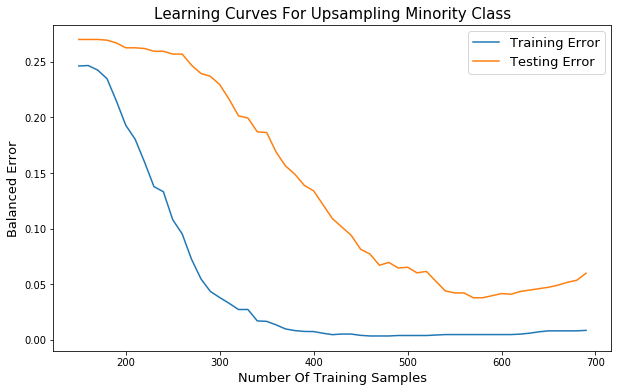

In [34]:
from functools import partial

# create function to create upsampling with only
# parameter being n_samples
upsample_train_test = partial(train_test_accuracy,
                              train_no_hockey_df, 
                              train_hockey_df, 
                              imbal_test_df,
                              False)
# create n_samples
minority_samples                = list(range(150,700,10))

# get the train/test error for each of the n_samples
train_min_accur, test_min_accur = zip(*map(upsample_train_test,minority_samples))

# plot the results
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,6))
plt.plot(minority_samples, train_min_accur, label="Training Error")
plt.plot(minority_samples, test_min_accur,  label="Testing Error")
plt.ylabel("Balanced Error",fontsize=13)
plt.xlabel("Number Of Training Samples",fontsize=13)
plt.title("Learning Curves For Upsampling Minority Class", fontsize=15)
plt.legend(fontsize=13)

From the growing gap between the training error and test error as we increase `n_samples` it's evident that were introducing some bias by upsampling the minjority class.  However, adding more miniority samples does decrease the test error so we'll hang on to it. Let's try downsampling the majority classes:

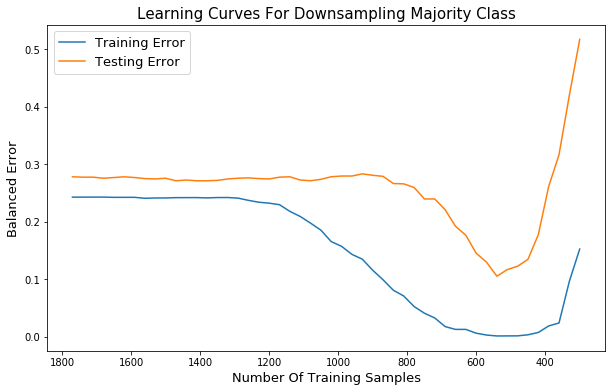

In [35]:
# create function to create downsampling with only
# parameter being n_samples
downsample_train_test = partial(train_test_accuracy,
                                train_no_hockey_df, 
                                train_hockey_df, 
                                imbal_test_df,
                                True)
# create n_samples
majority_samples                = [3*i for i in range(100,600,10)]

# get the train/test error for each of the n_samples
train_maj_accur, test_maj_accur = zip(*map(downsample_train_test,majority_samples))

# plot the results, but with x-axis reversed to see to make
# sense for downsampling
plt.figure(figsize=(10,6))
ax = plt.gca()
ax.invert_xaxis()

plt.plot(majority_samples, 
         train_maj_accur, 
         label="Training Error")

plt.plot(majority_samples, 
         test_maj_accur,  
         label="Testing Error")

plt.ylabel("Balanced Error",fontsize=13)
plt.xlabel("Number Of Training Samples",fontsize=13)
plt.title("Learning Curves For Downsampling Majority Class", fontsize=15)
plt.legend(fontsize=13)

Downsampling the majority classes just seems to increase the bias until the datasets classes are roughly even, but at that stage we have a very small sample size.  Nor does the training error decrease until around 1,100 samples.   It's a little weird looking, but as we increase the number of samples in the majority classes we increase the training error, this is counter intuitive! I believe this is because increasing the other classes' size increases the imbalance!

For now let's just stick to upsampling the minority class at the max we looked at, 500:

In [36]:
upsampled_hockey_df = resample(train_hockey_df,
                                replace=True,
                                n_samples=500,
                                random_state=123)

new_sampled_df = pd.concat([train_no_hockey_df, 
                            upsampled_hockey_df], 
                           axis=0)

model          = pipe.fit(new_sampled_df["text"], new_sampled_df["target"])

predicted      = model.predict(imbal_test_df["text"])

print(classification_report(imbal_test_df["target"],
                            predicted, 
                            target_names=new_labels))

print()
print("balanced_accuracy", balanced_accuracy_score(imbal_test_df["target"], 
                                                   predicted))

print("weighted f1 score:", f1_score(imbal_test_df["target"], 
                                     predicted, average="weighted"))

                    precision    recall  f1-score   support

         rec.autos       0.95      0.98      0.96       396
   rec.motorcycles       0.98      0.96      0.97       398
rec.sport.baseball       0.96      0.96      0.96       397
  rec.sport.hockey       0.88      0.84      0.86       100

          accuracy                           0.96      1291
         macro avg       0.94      0.93      0.94      1291
      weighted avg       0.96      0.96      0.96      1291


balanced_accuracy 0.9348236689515819
weighted f1 score: 0.9564594681637013


A pretty good improvment in our scores, but the precision/recall on hockey is still quite low.  Let's try another preprocessing routine to see if this improves our recall.

## Stop Words Removal <a class="anchor" id="sixth-bullet"></a>
------------

We can look to improve our model by removing <a href="https://en.wikipedia.org/wiki/Stop_words">stop words</a> which are common words in the english language and do not add any information into the text. These includes words such as, "the", "at", "is", etc.  Let's look at an example using the Natural Language Toolkit ([NLTK](https://www.nltk.org/#)).  First we get an example document,

In [38]:
# example document
doc_lines = imbal_train_df["text"].iloc[0].split("\n") 

print("\n".join(doc_lines))

From: kkeller@mail.sas.upenn.edu (Keith Keller)
Subject: Detroit-Toronto?
Organization: University of Pennsylvania, School of Arts and Sciences
Lines: 10
Nntp-Posting-Host: mail.sas.upenn.edu

What's the deal?  c.s.h. has nothing on it yet.  Is it in OT, is it over,
what?  I want to know!  We all want to know!  Where's Roger when you need
him?!?!?!?!  :-)

--
    Keith Keller				LET'S GO RANGERS!!!!!
						LET'S GO QUAKERS!!!!!
	kkeller@mail.sas.upenn.edu		IVY LEAGUE CHAMPS!!!!

	   "A cow is not a vegetarian dish."  -- Keith Keller, 1993



We import the nltk package and download the data required for stopwords.

In [39]:
import nltk
nltk.download()
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


Now we collect the stop words as a set. We have to do things in a funky way so that the formatting is the same as above.  `doc_lines` is a list where each entry in the line in the document. In order to preserve this we have to tokenize each line, filter it, then use join to make it a string again. We do this independently for each line in the list and then join the list of strings back and insert a "\n" between the filtered lines to make the format match the previous document.

In [40]:
# collect the stopwords
stop_words    = set(stopwords.words('english')) 

# tokenize each line in the list of lines 
lines_tokens  = [word_tokenize(line) for line in doc_lines]

# remove stop words from each line/list
filter_lines  = [" ".join([token for token in tokens if token not in stop_words])
                 for tokens in lines_tokens]

print("\n".join(filter_lines))

From : kkeller @ mail.sas.upenn.edu ( Keith Keller )
Subject : Detroit-Toronto ?
Organization : University Pennsylvania , School Arts Sciences
Lines : 10
Nntp-Posting-Host : mail.sas.upenn.edu

What 's deal ? c.s.h . nothing yet . Is OT , ,
? I want know ! We want know ! Where 's Roger need
? ! ? ! ? ! ? ! : - )

--
Keith Keller LET 'S GO RANGERS ! ! ! ! !
LET 'S GO QUAKERS ! ! ! ! !
kkeller @ mail.sas.upenn.edu IVY LEAGUE CHAMPS ! ! ! !

`` A cow vegetarian dish . '' -- Keith Keller , 1993



We can remove stop words in the `CountVectorizer` constructor call instead of using NLTK's stop word remover.  The sets of words are probably not the same, but they are probably close enough. 

In [42]:
pipe      = Pipeline([('vec', CountVectorizer(stop_words="english")),
                      ('tfidf', TfidfTransformer()),
                      ('model', MultinomialNB())])

model     = pipe.fit(new_sampled_df["text"], new_sampled_df["target"])

predicted = model.predict(imbal_test_df["text"])

print(classification_report(imbal_test_df["target"],
                            predicted, 
                            target_names=new_labels))
print()
print("balanced_accuracy", balanced_accuracy_score(imbal_test_df["target"], 
                                                   predicted))

print("weighted f1 score:", f1_score(imbal_test_df["target"], 
                                     predicted, 
                                     average="weighted"))

                    precision    recall  f1-score   support

         rec.autos       0.96      0.97      0.96       396
   rec.motorcycles       0.98      0.97      0.97       398
rec.sport.baseball       0.97      0.97      0.97       397
  rec.sport.hockey       0.89      0.89      0.89       100

          accuracy                           0.96      1291
         macro avg       0.95      0.95      0.95      1291
      weighted avg       0.96      0.96      0.96      1291


balanced_accuracy 0.9492017382155415
weighted f1 score: 0.9628347818340964


We can see that removing stop words gives us a decent improvement in our recall and f1-score!  Next we'll look at hyperparameter tunning to see if we can improve the model performance.

## HyperParameter Tuning With GridSearchCV <a class="anchor" id="seventh-bullet"></a>
----------------

Not only do Scikit-learn pipelines allow us to swap out our model much easier, (say replace our Naive Bayes classifier with a support vector classifier), but they also allow us to assemble several steps that can be cross-validated together while choosing different parameters. 

The hyperparameters we want to look at:

    - min_df : When building the vocabulary ignore terms that have a document frequency strictly lower than this #
    
    - smooth_idf : Smooth idf weights by adding one to document frequencies
    
    - use_idf : Enable inverse-document-frequency reweighting
    
    - alpha : Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing)
    
    - fit_prior : Whether to learn class prior probabilities or not. If false, a uniform prior will be used.
    

To try different values of the hyperparametrs, pipelines enable setting parameters of the various steps using the pipeline stage name and the parameter name separated by a ‘__’.  

In [43]:
from sklearn.model_selection import GridSearchCV
params = {'vec__min_df': (1,3),
          'tfidf__smooth_idf': (True, False),
          'tfidf__use_idf': (True, False),
          'model__alpha': (1, 1e-1, 1e-2, 1e-3),
          'model__fit_prior': (True,False)}

Notice how when we wish to change the model parameter `alpha` (which is a smoothing regularizer) by including on "model" and not the `model` object. We can perform the grid search with 5-fold cross validation in parallel by setting `cv = 5` and `n_jobs=-1`.  We use our scoring metric as `balanced_accuracy` to account for the imbalanced classes when doing the grid search.  This is the way we tune our algorithm for handling imbalanced data.

In [44]:
pipe = Pipeline([('vec', CountVectorizer(stop_words="english")),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB())])

# 5 fold cross validation
grid_search = GridSearchCV(estimator  = pipe, 
                           param_grid = params, 
                           scoring    = "balanced_accuracy",
                           cv         = 5,
                           n_jobs     =-1)

We can then fit the data to perform the actual grid search,

In [45]:
gs_model = grid_search.fit(new_sampled_df["text"], 
                           new_sampled_df["target"])

Our model `gs_model` uses the paremeters which had the best cross-validated score. We can see a full description of the best model,

In [46]:
print(gs_model.best_estimator_)

Pipeline(memory=None,
         steps=[('vec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=False)),
                ('model',
                 MultinomialNB(alpha=0.1, class_prior=None, fit_prior=False))],
         verbose=False)


As well as it's performance:

In [47]:
predicted = gs_model.predict(imbal_test_df["text"])
print(classification_report(imbal_test_df["target"],
                            predicted, 
                            target_names=new_labels))
print()
print("balanced_accuracy", balanced_accuracy_score(imbal_test_df["target"], 
                                                   predicted))

print("weighted f1 score:", f1_score(imbal_test_df["target"], 
                                     predicted, 
                                     average="weighted"))


                    precision    recall  f1-score   support

         rec.autos       0.96      0.97      0.97       396
   rec.motorcycles       0.98      0.97      0.97       398
rec.sport.baseball       0.97      0.97      0.97       397
  rec.sport.hockey       0.89      0.91      0.90       100

          accuracy                           0.96      1291
         macro avg       0.95      0.95      0.95      1291
      weighted avg       0.96      0.96      0.96      1291


balanced_accuracy 0.9542001559971448
weighted f1 score: 0.9644306178887715


We can see that we can improve the model performance and overall we are doing very well! Let's see how a grid search would have peformed on the full data with balanced classes:

In [48]:
grid_search_orig = GridSearchCV(estimator  = pipe, 
                                param_grid = params, 
                                scoring    = "accuracy",
                                cv         = 5,
                                n_jobs     =-1)

gs_model_orig    = grid_search_orig.fit(train_df["text"], 
                                        train_df["target"])

predicted        = gs_model_orig.predict(test_df["text"])
 
print(classification_report(test_df["target"],
                            predicted, 
                            target_names=new_labels))

print()
print("accuracy", accuracy_score(test_df["target"], 
                                 predicted))

                    precision    recall  f1-score   support

         rec.autos       0.96      0.97      0.96       396
   rec.motorcycles       0.98      0.97      0.97       398
rec.sport.baseball       0.97      0.95      0.96       397
  rec.sport.hockey       0.96      0.98      0.97       399

          accuracy                           0.97      1590
         macro avg       0.97      0.97      0.97      1590
      weighted avg       0.97      0.97      0.97      1590


accuracy 0.9672955974842767


We can see that our model's overall performance on the imbalanced class dataset is almost as good as a model on the balanced dataset! The recall for hockey is still much lower than the balanced dataset, but much better than where we started from. 

## Conclusions <a class="anchor" id="eigth-bullet"></a>


In this blogpost we covered document classification using Scikit-learn and on a subset of 20 News Groups dataset that has one class that is imbalanced.  We went over the basics of term frequency-inverse document frequency, pipelines and the Naive Bayes classifier.  While we were able to improve the balanced accuracy of the basic Naive Bayes classifier from 73% to 95% and weighted f1 score from 86% to 96%. There are much more sophisticated models like a <a href="http://scikit-learn.org/stable/modules/svm.html#svm">support vector classifiers</a> that may achieve higher performance, but they take substantially more time to train and therefore decided against using for this blogpost.

One thing that we did not address was the topic of <a href="https://en.wikipedia.org/wiki/Stemming">stemming</a> and <a href="https://en.wikipedia.org/wiki/Lemmatisation">lemmatisation</a>, which both have to do with reducing a word down to its base form and when used can improve the performance of text classification models. Lemmatisation differs from stemming because it depends on identifying the intended part of speech and meaning of a word in a sentence. I did try a few of the stemmers and lemmatizers provided by NLTK, but for this blogpost the marginal improvment was not worth the increased time to train the model.